In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nengo
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt

## Aaron's original method 

In [4]:
def go(transition=[0, 1],
       ensemble_seed=0,
       n=50,
       neuron_type=nengo.AdaptiveLIFRate(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=0.5),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False):

    d = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
    
    A = 2*np.pi*freq
    syn_train=nengo.Lowpass(tau)

    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: A*np.cos(A*t))
            presyn = nengo.Node(size_in=1)  # tau*dot{x} + x == tau*u + int{u}
            x = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=ensemble_seed)
            
            nengo.Connection(stim, presyn, synapse=None, transform=tau)
            nengo.Connection(x, presyn, synapse=None, transform=p,
                             solver=nengo.solvers.NoSolver(d))
            nengo.Connection(stim, presyn, synapse=1/s, transform=1-p)
            nengo.Connection(presyn, x, synapse=tau)
            
            p_a = nengo.Probe(x.neurons, synapse=None)
            p_x = nengo.Probe(presyn, synapse=tau)
            p_y = nengo.Probe(stim, synapse=1/s)
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)

        new_d, _ = solver(syn_train.filt(sim.data[p_a]),
                          syn_train.filt(sim.data[p_y]))
        e = nengolib.signal.nrmse(sim.data[p_x], target=sim.data[p_y])
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(new_d - d)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
        d = new_d
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), sim.data[p_y], label=r"$x$", linestyle='--')
            plt.plot(sim.trange(), sim.data[p_x], label=r"$\hat{x}$")
            plt.legend()
            plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


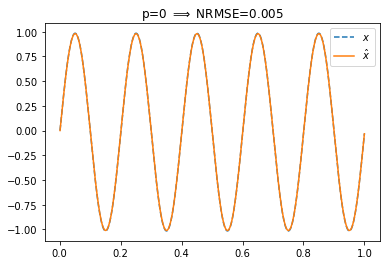

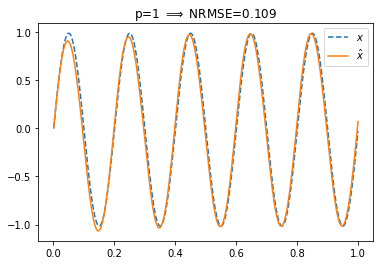

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


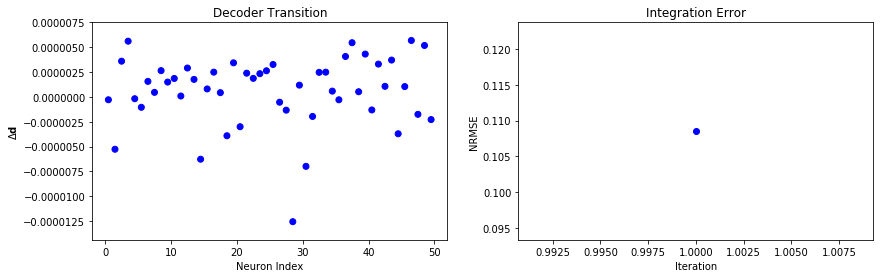

In [5]:
go(verbose=True)

Stable transition, consistently higher error

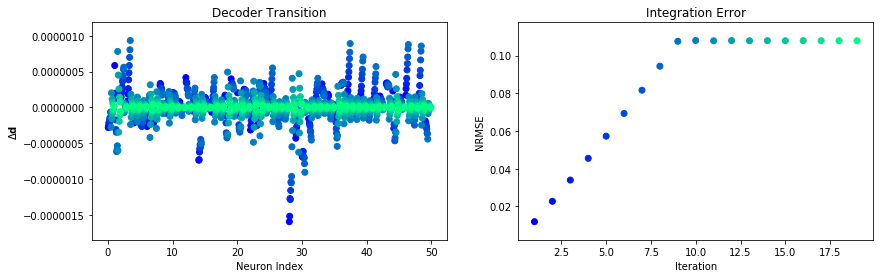

In [6]:
go(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))))

Unstable transition, lower initial error but oscillating $\Delta \mathbf{d}$ and growing error after transition

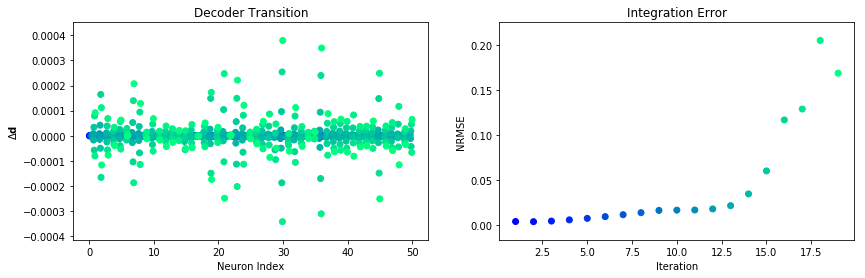

In [7]:
go(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
   solver=nengo.solvers.LstsqL2(reg=0.1))

## New method uses a network has fully spiking recurrence and training
And hence supports neuron_type=Bahlneuron() substituion

In [45]:
def go2(transition=[0, 1],
       es=0,
       cs=1,
       n=50,
       neuron_type=nengo.AdaptiveLIFRate(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=0.5),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False,
       spikes2inter=False,
       n_pre2=50,
       tau_pre2=0.01):

    d_bio = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
 
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    lpf2=nengo.Lowpass(tau_pre2)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_ff = np.max(np.abs(target_ff))
    norm_f2f = np.max(np.abs(target_f2f))
    
    # now solve for "inter" decoders, which will be used to compute
    # weights on the inter_bio connection
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre2, synapse=1/s)
        nengo.Connection(pre2, inter, synapse=tau_pre2, transform=1.0/norm_f2f, seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f2f)
        p_a = nengo.Probe(inter.neurons, synapse=None)
        p_integral = nengo.Probe(tar, synapse=None)     
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    act_f = lpf.filt(sim.data[p_a])
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    d_inter, _ = solver(act_f, target_f2f)
    xhat_inter = np.dot(act_f, d_inter)
    e_inter = nengolib.signal.nrmse(xhat_inter, target=target_f2f)
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode $\Longrightarrow$ NRMSE=%.3f" %e_inter)
        plt.plot(sim.trange(), target_f2f, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_inter, label=r"$\hat{x}$")
        plt.legend()
        plt.show()

        
    # now solve for the readout/recurrent decoders
    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
            pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
            pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(pre, bio, synapse=tau, transform=tau/norm_f, seed=cs)
            nengo.Connection(stim, pre2, synapse=1/s)
            nengo.Connection(pre2, inter, synapse=tau_pre2, transform=1.0/norm_f, seed=cs)
            nengo.Connection(bio, bio,
                             synapse=tau,
                             transform=p,
                             solver=nengo.solvers.NoSolver(d_bio),
                             seed=cs)
            nengo.Connection(inter, bio,
                             synapse=tau,
                             transform=1-p,
                             solver=nengo.solvers.NoSolver(d_inter),
                             seed=cs)
            nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)
            
            p_a = nengo.Probe(bio.neurons, synapse=None)
            p_i = nengo.Probe(inter, synapse=tau, solver=nengo.solvers.NoSolver(d_inter))
            p_integral = nengo.Probe(tar, synapse=None)
            p_bio = nengo.Probe(bio, synapse=tau, solver=nengo.solvers.NoSolver(d_bio))
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)
        
        act_f = lpf.filt(sim.data[p_a])
        target_f = lpf.filt(sim.data[p_integral])
        target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
        d_bio_new, _ = solver(act_f, target_f)
        xhat_bio = np.dot(act_f, d_bio_new)
        e = nengolib.signal.nrmse(xhat_bio, target=target_f)
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(d_bio_new - d_bio)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
            
        d_bio = d_bio_new
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), target_f, label=r"$x_f$", linestyle='--')
#             plt.plot(sim.trange(), target_ff, label=r"$x_{ff}$", linestyle='--')
            plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
#             plt.plot(sim.trange(), sim.data[p_i], label=r"$\hat{x}_{inter}$")
            plt.legend()
            plt.show()
#             plt.figure()
#             plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
#             plt.plot(sim.trange(), act_f, label=r"$a$", linestyle='-')
#             plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

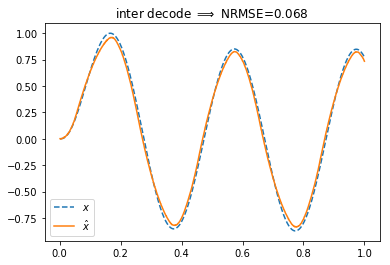

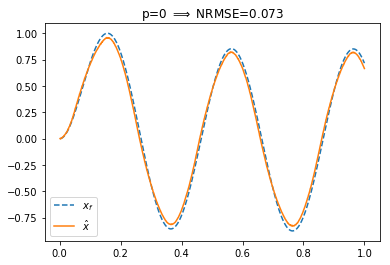

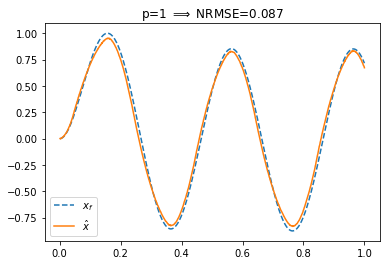

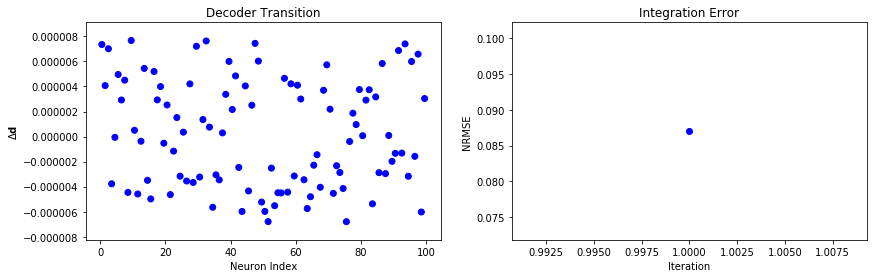

In [46]:
go2(n=100,
    freq=5*np.pi,
    verbose=True,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01)

Unstable transition, low initial error

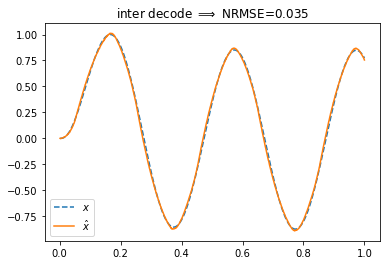

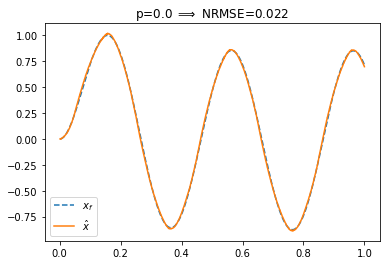

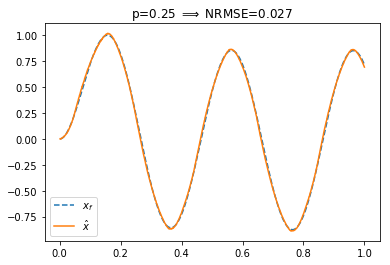

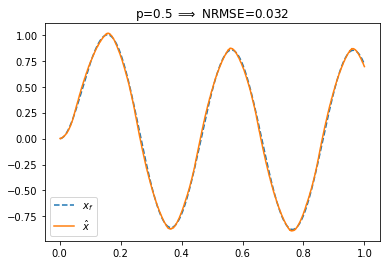

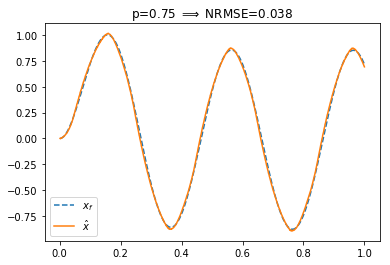

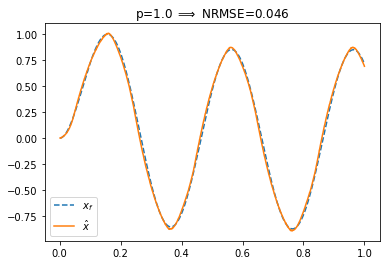

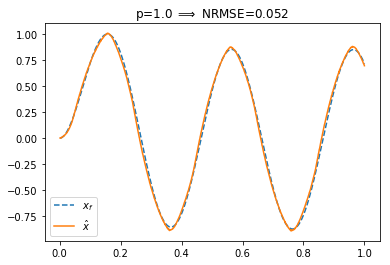

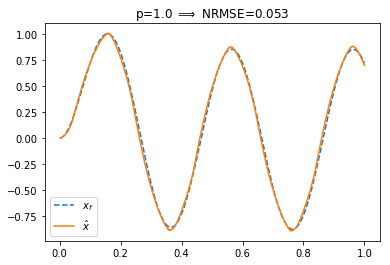

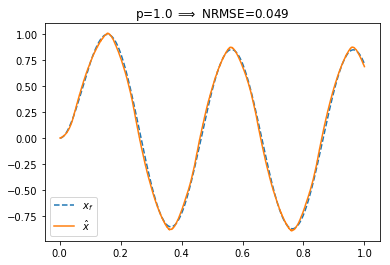

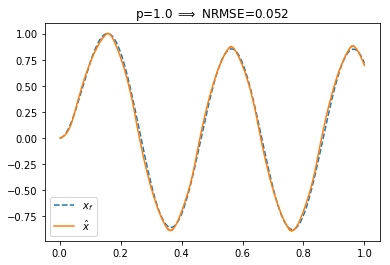

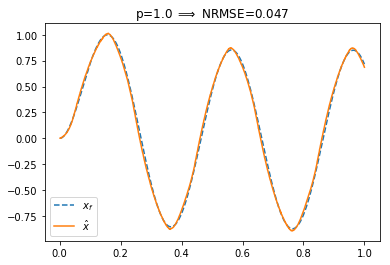

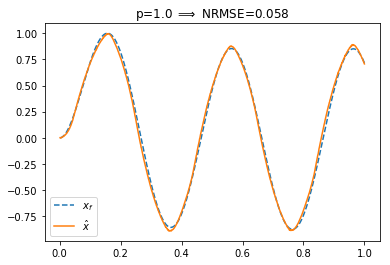

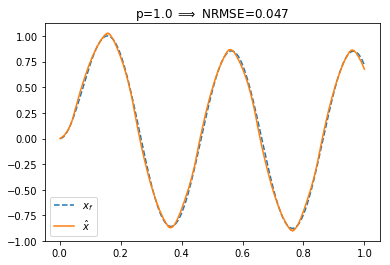

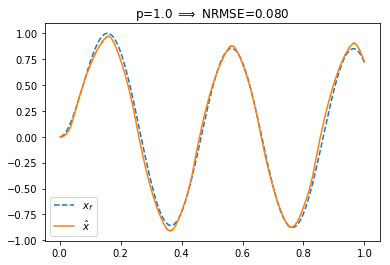

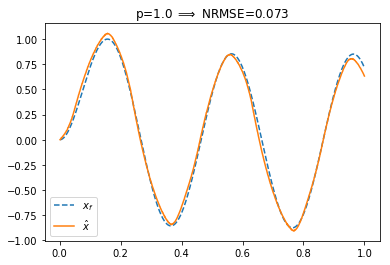

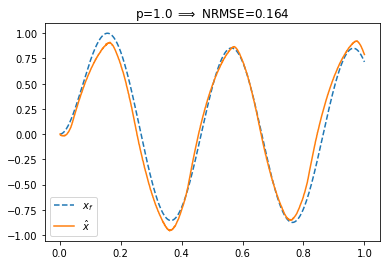

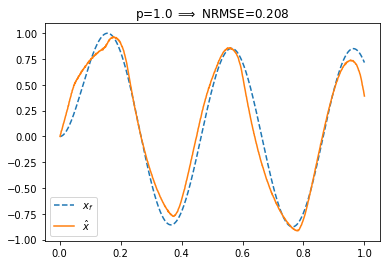

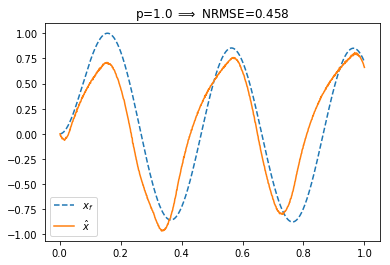

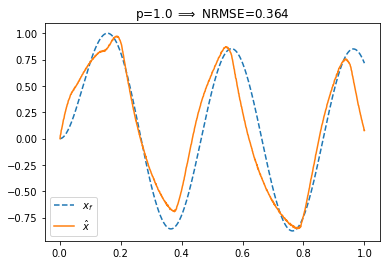

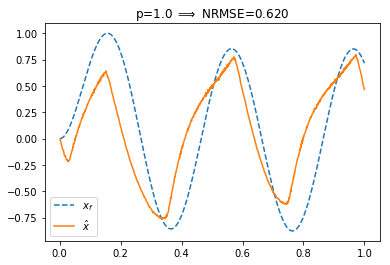

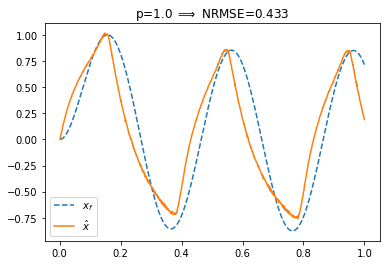

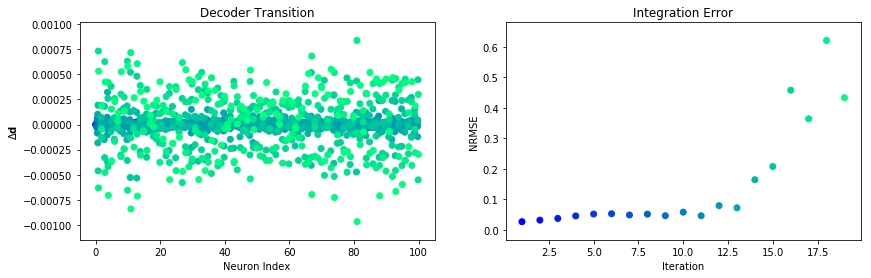

In [47]:
go2(np.concatenate((np.linspace(0, 1, 5), np.repeat(1, 15))),
    n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=0.1),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01)

Stable transition, consistently higher error

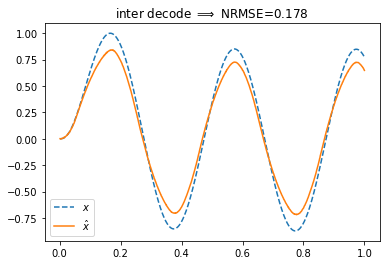

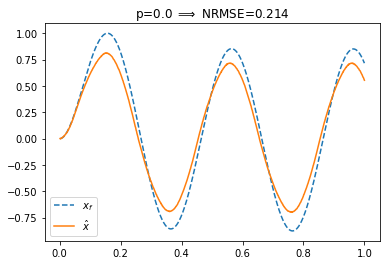

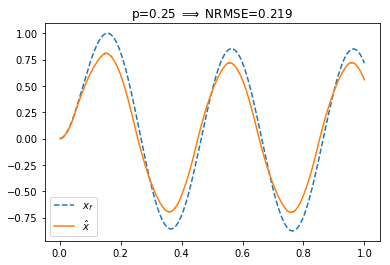

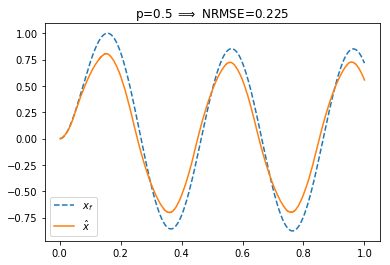

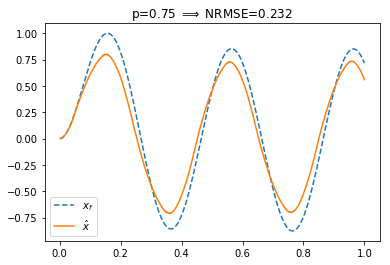

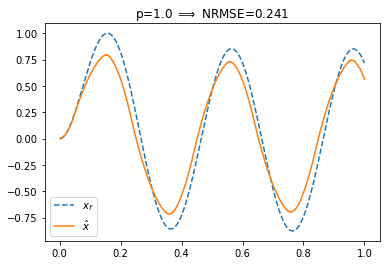

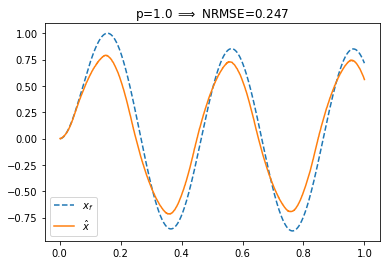

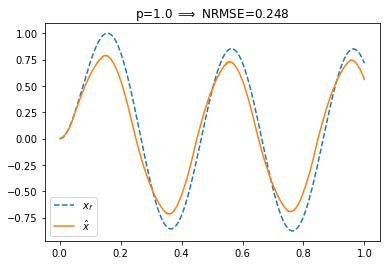

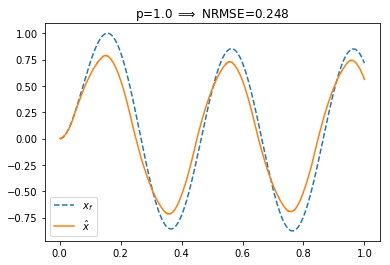

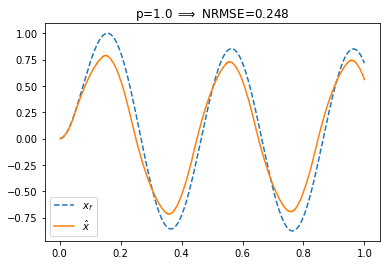

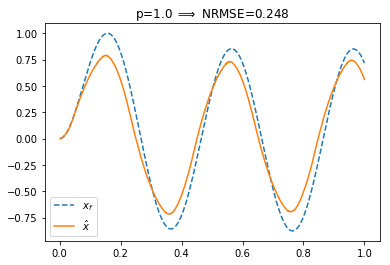

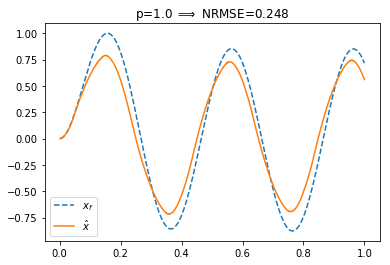

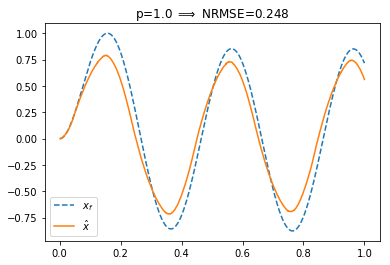

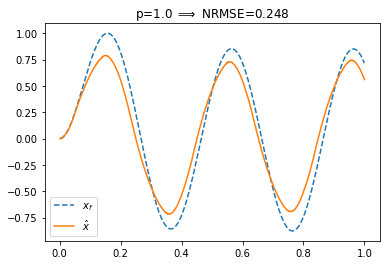

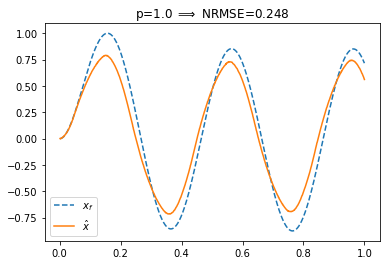

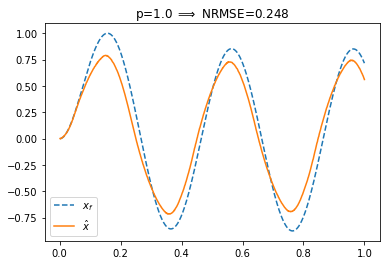

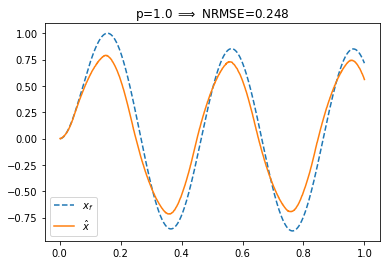

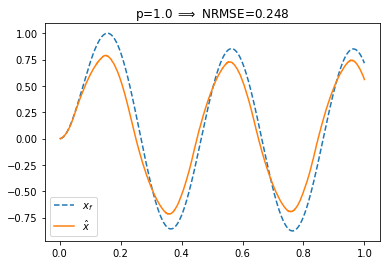

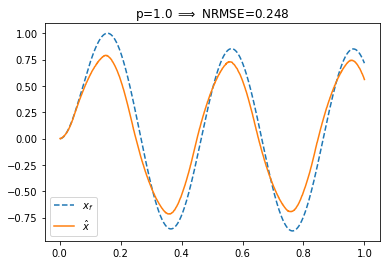

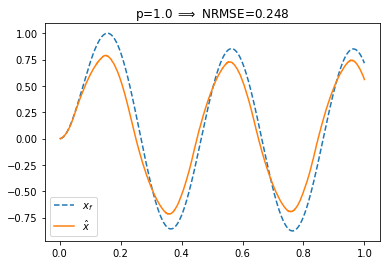

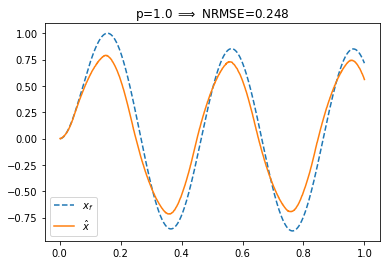

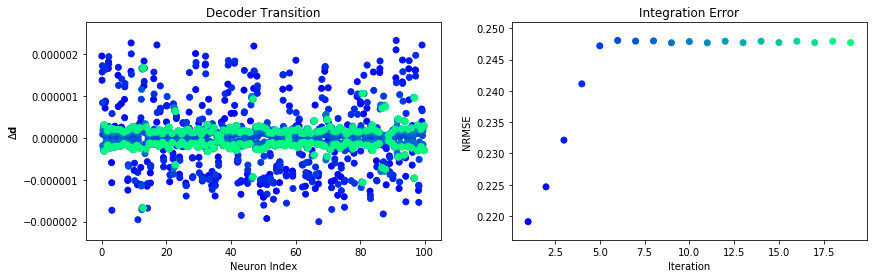

In [13]:
go2(np.concatenate((np.linspace(0, 1, 5), np.repeat(1, 15))),
    n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=1.0),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01)

After some testing, looks like using a low reg (reg=0.1) leads to very high accuracy just after the transition, but continuing to apply decoder update leads to oscillating exponential noise, as Aaron pointed out for go(). Higher reg (reg>0.9) leads to lower accuracy (consistent undershoot of the signal), but no grown in the error oscillation.

## Onto the Bioneurons!

In [40]:
from nengo_bioneurons import BahlNeuron, build_filter

def go3(transition=[0, 1],
       es=0,
       cs=1,
       n=100,
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       inter_solver=nengo.solvers.LstsqL2(reg=0.1),
       solver=nengo.solvers.LstsqL2(reg=1.0),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False,
       n_pre2=100,
       tau_pre2=0.01,
       n_syn=1,
       h_out=nengo.Lowpass(0.1),
       sec='apical'):

    d_bio = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
 
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    lpf2=nengo.Lowpass(tau_pre2)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = h_out.filt(sim.data[p_integral])
    target_f2f = h_out.filt(lpf2.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_f2f = np.max(np.abs(target_f2f))
    
    # now solve for "inter" decoders, which will be used to compute
    # weights on the inter_bio connection
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre2, synapse=1/s)
        nengo.Connection(pre2, inter,
                         sec=sec,
                         n_syn=n_syn,
                         syn_type='ExpSyn',
                         tau_list=[tau_pre2],
                         synapse=tau_pre2,
                         transform=1.0/norm_f2f,
                         seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f2f)
        p_a = nengo.Probe(inter.neurons, synapse=None)
        p_integral = nengo.Probe(tar, synapse=None)     
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
    act_f = h_out.filt(sim.data[p_a])
    target_f2f = h_out.filt(lpf2.filt(sim.data[p_integral]))
    d_inter, _ = inter_solver(act_f, target_f2f)
    xhat_inter = np.dot(act_f, d_inter)
    e_inter = nengolib.signal.nrmse(xhat_inter, target=target_f2f)
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode $\Longrightarrow$ NRMSE=%.3f" %e_inter)
        plt.plot(sim.trange(), target_f2f, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_inter, label=r"$\hat{x}$")
        plt.legend()
        plt.show()

        
    # now solve for the readout/recurrent decoders
    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
            pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
            pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(pre, bio,
                             sec=sec,
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=tau/norm_f,
                             seed=cs)
            nengo.Connection(stim, pre2, synapse=1/s)
            nengo.Connection(pre2, inter,
                             sec=sec,
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau_pre2],
                             synapse=tau_pre2,
                             transform=1.0/norm_f,
                             seed=cs)
            nengo.Connection(bio, bio,
                             sec=sec,
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=p,
                             solver=nengo.solvers.NoSolver(d_bio),
                             seed=cs)
            nengo.Connection(inter, bio,
                             sec=sec,
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=1-p,
                             solver=nengo.solvers.NoSolver(d_inter),
                             seed=cs)
            nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)
            
            p_a = nengo.Probe(bio.neurons, synapse=None)
            p_i = nengo.Probe(inter, synapse=h_out, solver=nengo.solvers.NoSolver(d_inter))
            p_integral = nengo.Probe(tar, synapse=None)
            p_bio = nengo.Probe(bio, synapse=h_out, solver=nengo.solvers.NoSolver(d_bio))
            
        with nengo.Simulator(model, progress_bar=verbose) as sim:
            sim.run(t, progress_bar=verbose)
        
        act_f = h_out.filt(sim.data[p_a])
        target_f = h_out.filt(sim.data[p_integral])
        d_bio_new, _ = solver(act_f, target_f)
        xhat_bio = np.dot(act_f, d_bio_new)
        e = nengolib.signal.nrmse(xhat_bio, target=target_f)
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(d_bio_new - d_bio)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
            
        d_bio_old = d_bio
        d_bio = d_bio_new
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), target_f, label=r"$x_f$", linestyle='--')
            plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
            plt.plot(sim.trange(), sim.data[p_i], label=r"$\hat{x}_{inter}$")
            plt.legend()
            plt.show()
#             plt.figure()
#             plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
#             plt.plot(sim.trange(), act_f, label=r"$a$", linestyle='-')
#             plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()
    
    return d_inter, d_bio, h_out

In [41]:
def test(d_bio,
       signal='cos',
       es=0,
       cs=1,
       ss=2,
       n=100,
       tau=0.1,
       freq=5,
       t=1,
       n_syn=1,
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       h_out=nengo.Lowpass(0.1),
       sec='apical',
       verbose=False):
    
    # first find the norm of the filtered signal
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
        
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
        
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = h_out.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    # now run the full simulations with the appropriate normalizing transforms
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
        bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)

        nengo.Connection(stim, pre, synapse=None)
        nengo.Connection(pre, bio,
                         sec=sec,
                         n_syn=n_syn,
                         syn_type='ExpSyn',
                         tau_list=[tau],
                         synapse=tau,
                         transform=tau/norm_f,
                         seed=cs)
        nengo.Connection(bio, bio,
                         sec=sec,
                         n_syn=n_syn,
                         syn_type='ExpSyn',
                         tau_list=[tau],
                         synapse=tau,
                         solver=nengo.solvers.NoSolver(d_bio),
                         seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)

#         p_act = nengo.Probe(bio.neurons, synapse=None)
        p_target = nengo.Probe(tar, synapse=h_out)
        p_bio = nengo.Probe(bio, synapse=h_out, solver=nengo.solvers.NoSolver(d_bio))

    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)

    target = sim.data[p_target]
    xhat_bio = sim.data[p_bio]
    e = nengolib.signal.nrmse(xhat_bio, target=target)
    
    plt.figure()
    plt.title(r"NRMSE=%.3f" % (e))
    plt.plot(sim.trange(), target, label=r"$x$", linestyle='--')
    plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
    plt.legend()
    plt.show()

ALIF with reg=1.0

In [ ]:
_, _, _ = go3(n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=1.0),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01,
    t=1.0,
    n_syn=1)

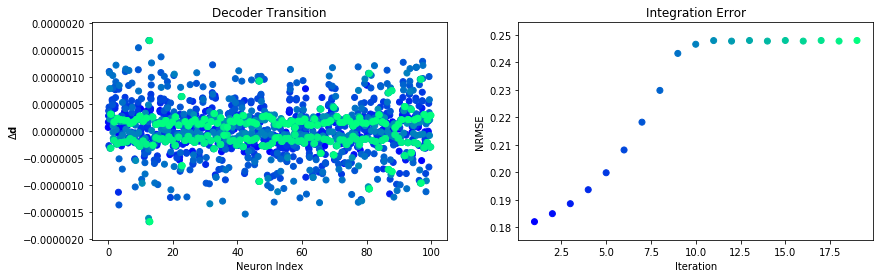

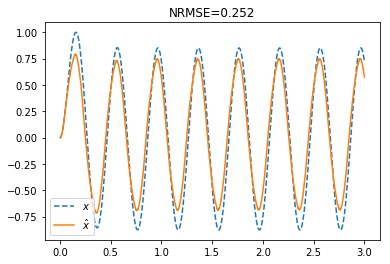

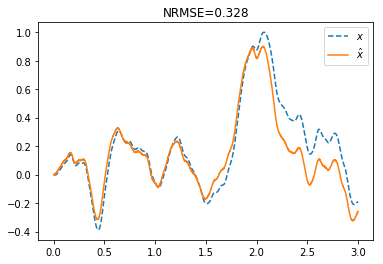

In [44]:
d_inter, d_bio, h_out = go3(
    np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    freq=5*np.pi,
    verbose=False,
    solver=nengo.solvers.LstsqL2(reg=1.0),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0,
    n_syn=1)

test(d_bio,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

test(d_bio,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

ALIF with reg=0.1

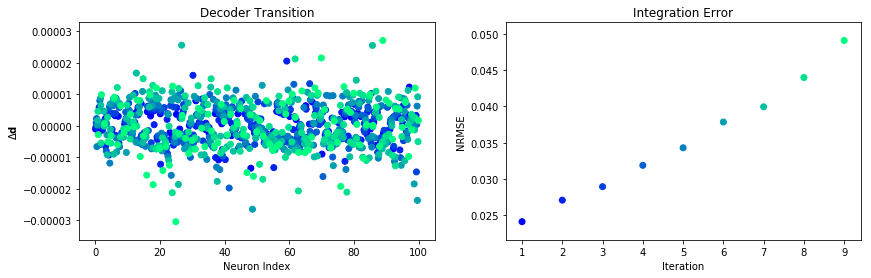

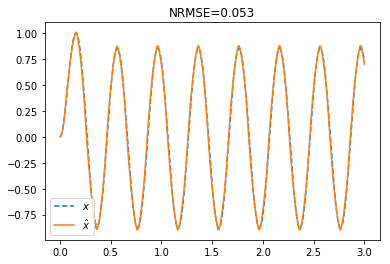

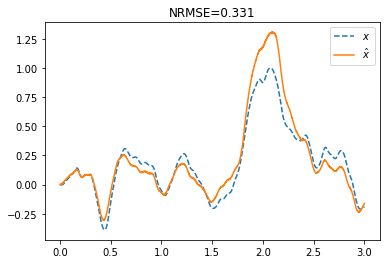

In [45]:
d_inter, d_bio, h_out = go3(
    np.linspace(0, 1, 10),
    freq=5*np.pi,
    verbose=False,
    solver=nengo.solvers.LstsqL2(reg=0.1),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0,
    n_syn=1)

test(d_bio,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

test(d_bio,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

Seems like both regularization values perform well on the test set

### Bioneuron testing
reg=1.0, sec='apical'

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:26.                                                 


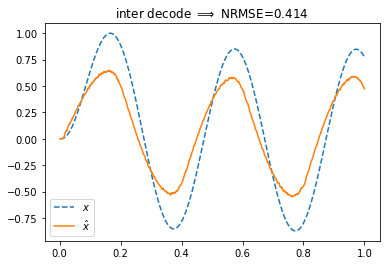

Building finished in 0:00:03.                                                   
Simulating finished in 0:04:24.                                                 


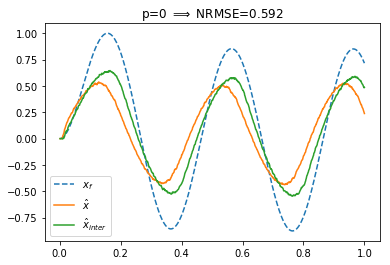

Building finished in 0:00:02.                                                   
Simulating finished in 0:04:18.                                                 


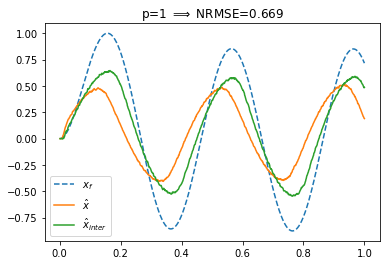

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:05:38.                                                 


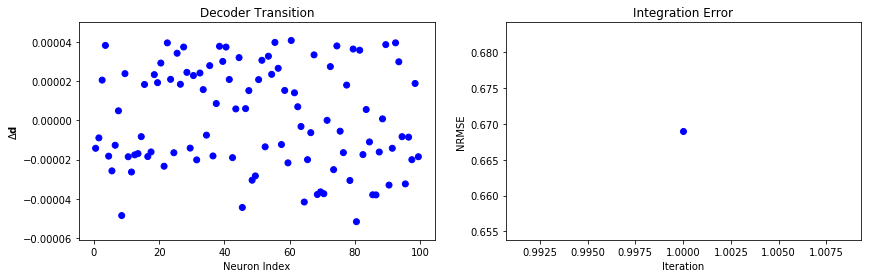

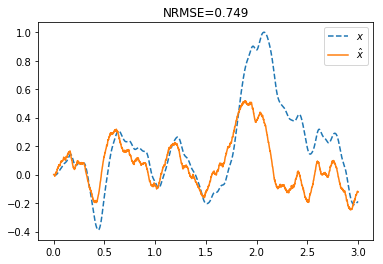

In [37]:
d_inter, d_bio, h_out = go3(n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=1.0),
    neuron_type=BahlNeuron(),
    t=1.0,
    n_syn=1)

test(d_bio,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True)

reg=0.1, sec='apical'

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:34.                                                 


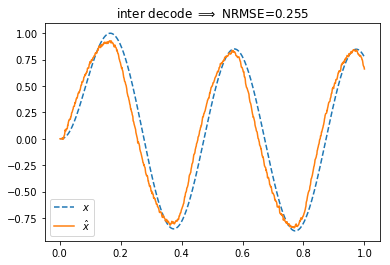

Building finished in 0:00:02.                                                   
Simulating finished in 0:05:21.                                                 


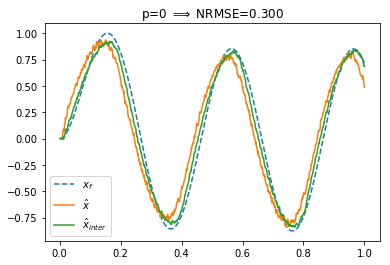

Building finished in 0:00:02.                                                   
Simulating finished in 0:06:34.                                                 


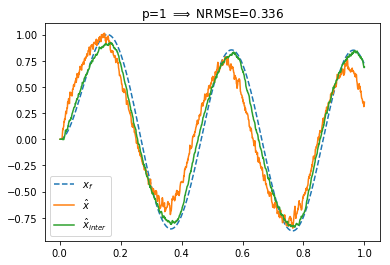

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:06:45.                                                 


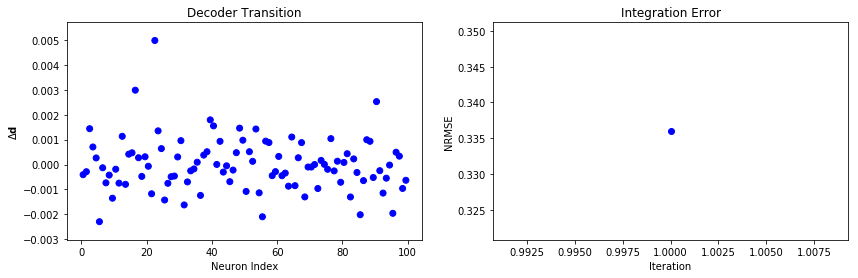

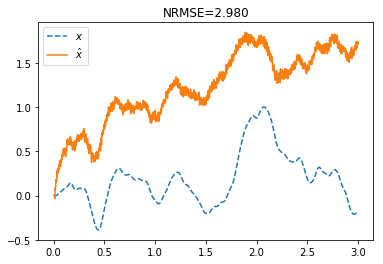

In [38]:
d_inter, d_bio, h_out = go3(n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=0.1),
    neuron_type=BahlNeuron(),
    t=1.0,
    n_syn=1)

test(d_bio,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True)

reg=1.0, sec='tuft'

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:51.                                                 


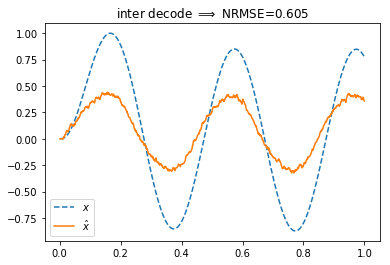

Building finished in 0:00:02.                                                   
Simulating finished in 0:06:57.                                                 


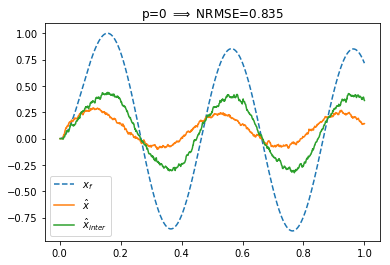

Building finished in 0:00:02.                                                   
Simulating finished in 0:06:59.                                                 


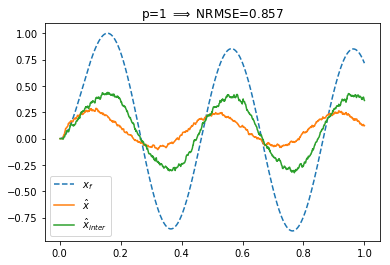

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:06:52.                                                 


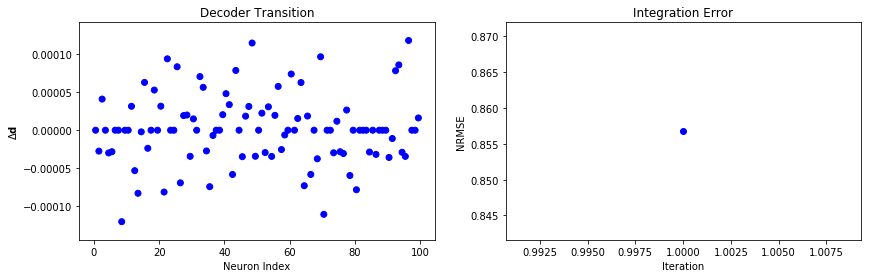

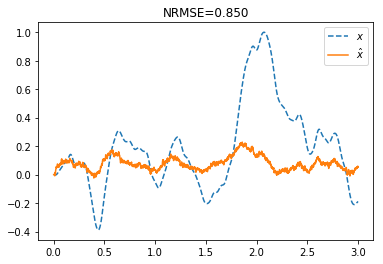

In [39]:
d_inter, d_bio, h_out = go3(n=100,
    sec='tuft',                        
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=1.0),
    neuron_type=BahlNeuron(),
    t=1.0,
    n_syn=1)

test(d_bio,
     sec='tuft',
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True)